In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

print("Libraries Imported ✅")


Libraries Imported ✅


In [2]:
# Load dataset
file_path = "/content/COMP1816_Housing_Dataset_Regression.csv"
df = pd.read_csv(file_path)

print(df.head())  # Check first few rows

# Check missing values BEFORE handling
print("❌ Missing values BEFORE handling:\n", df.isnull().sum())

# Handle missing values
num_imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include=['number']).columns] = num_imputer.fit_transform(df.select_dtypes(include=['number']))

# Handle missing values for categorical features (ocean_proximity)
df['ocean_proximity'] = df['ocean_proximity'].replace('nan', np.nan)  # Convert 'nan' string back to actual NaN
df['ocean_proximity'] = df['ocean_proximity'].fillna(df['ocean_proximity'].mode()[0])  # Fill with mode

# Convert 'ocean_proximity' to categorical
df['ocean_proximity'] = df['ocean_proximity'].astype(str)

# Drop unnecessary column
df.drop(columns=['No.'], inplace=True, errors='ignore')


# Feature Engineering
df['income_rooms_interaction'] = df['median_income'] * df['total_rooms']

# Define features (X) and target variable (y)
X = df.drop(columns=['median_house_value'])
y = df['median_house_value']

# Check missing values AFTER handling
print("✅ Missing values AFTER handling:\n", df.isnull().sum())

print(df.info())  # Check data types & missing values
print(df.describe())  # Get summary statistics

print("✅ Dataset Preprocessing Completed")

print("Unique values in 'ocean_proximity' after handling:", df['ocean_proximity'].unique())
print("Missing values in 'ocean_proximity' after handling:", df['ocean_proximity'].isnull().sum())




   No.  longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    1    -122.12     37.70                  17         2488           617.0   
1    2    -122.21     38.10                  36         3018           557.0   
2    3    -122.22     38.11                  43         1939           353.0   
3    4    -122.20     37.78                  52         2300           443.0   
4    5    -122.19     37.79                  50          954           217.0   

   population  households  median_income  median_house_value ocean_proximity  
0        1287         538         2.9922              179900        NEAR BAY  
1        1445         556         3.8029              129900        NEAR BAY  
2         968         392         3.1848              112700        NEAR BAY  
3        1225         423         3.5398              158400        NEAR BAY  
4         546         201         2.6667              172800        NEAR BAY  
❌ Missing values BEFORE handling:
 No.       

In [3]:
# Define preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=2, include_bias=False))  # Polynomial Features
    ]), ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'income_rooms_interaction']),
    ('cat', OneHotEncoder(drop='first'), ['ocean_proximity'])
])

print("Preprocessing Pipeline Defined ✅")


Preprocessing Pipeline Defined ✅


In [4]:
# Splitting Data
test_size = 190
X_train, X_test = X.iloc[:-test_size, :], X.iloc[-test_size:, :]
y_train, y_test = y.iloc[:-test_size], y.iloc[-test_size:]

# Transform Data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(f"Training Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")
print("Data Splitting & Transformation Completed ✅")


Training Set: 810 samples
Test Set: 190 samples
Data Splitting & Transformation Completed ✅


In [5]:
# Define Advanced Random Forest hyperparameter grid
param_grid_rf = {
    'n_estimators': [100, 300, 500],  # Increase number of trees
    'max_depth': [5, 10, 20, 30],  # Deeper trees may capture more patterns
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples per leaf to prevent deep trees
    'max_features': [None, 'sqrt', 'log2'],  # Number of features considered per split
    'bootstrap': [True, False]  # Whether to bootstrap samples
}

# Perform RandomizedSearchCV for Random Forest with the new parameters
rf_search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42),
    param_distributions=param_grid_rf,
    n_iter=20,  # More iterations to search a wider range of parameters
    cv=5,
    scoring='r2',
    n_jobs=-1,
    error_score='raise',
    random_state=42
)

rf_search.fit(X_train_transformed, y_train)



# Define XGBoost hyperparameter grid
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'subsample': [0.7, 0.8, 0.9]
}

# Perform RandomizedSearchCV for XGBoost
xgb_search = RandomizedSearchCV(
    XGBRegressor(random_state=42),
    param_grid_xgb,
    n_iter=10,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)
xgb_search.fit(X_train_transformed, y_train)

# Retrieve Best Models
best_rf = rf_search.best_estimator_
best_xgb = xgb_search.best_estimator_

print("Best Random Forest Parameters:", rf_search.best_params_)
print("Best XGBoost Parameters:", xgb_search.best_params_)
print("Hyperparameter Tuning Completed ✅")


Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20, 'bootstrap': True}
Best XGBoost Parameters: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}
Hyperparameter Tuning Completed ✅


In [6]:
# Train Improved Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train_transformed, y_train)

# Get Predictions (Without Log Transformation)
y_pred_linear = linear_model.predict(X_test_transformed)

# Train Random Forest (Main Model)
best_rf.fit(X_train_transformed, y_train)

# Train XGBoost
best_xgb.fit(X_train_transformed, y_train)

print("All Models Trained ✅")


All Models Trained ✅


In [7]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

rf_cv_scores = cross_val_score(best_rf, X_train_transformed, y_train, cv=cv, scoring='r2')
xgb_cv_scores = cross_val_score(best_xgb, X_train_transformed, y_train, cv=cv, scoring='r2')
linear_cv_scores = cross_val_score(linear_model, X_train_transformed, y_train, cv=cv, scoring='r2')

print("Random Forest Cross-Validation R²:", np.mean(rf_cv_scores))
print("XGBoost Cross-Validation R²:", np.mean(xgb_cv_scores))
print("Linear Regression Cross-Validation R²:", np.mean(linear_cv_scores))


Random Forest Cross-Validation R²: 0.619306196970515
XGBoost Cross-Validation R²: 0.6379495352033755
Linear Regression Cross-Validation R²: 0.5444002714595244


In [8]:
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

def evaluate_model(y_true, y_pred, model_name, X):
    y_pred = np.clip(y_pred, 0, None)  # Ensure no negative predictions
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = adjusted_r2(r2, X.shape[0], X.shape[1])
    print(f"{model_name} - MSE: {mse:.2f}, R² Score: {r2:.4f}, Adjusted R²: {adj_r2:.4f}")


# No need to transform predictions back
y_pred_rf = best_rf.predict(X_test_transformed)
y_pred_xgb = best_xgb.predict(X_test_transformed)
y_pred_linear = linear_model.predict(X_test_transformed)

# No need to transform actual values
y_test_original = y_test

# Evaluate Each Model
evaluate_model(y_test, y_pred_rf, "Random Forest (Main Model)", X_test_transformed)
evaluate_model(y_test, y_pred_xgb, "XGBoost (Baseline)", X_test_transformed)
evaluate_model(y_test, y_pred_linear, "Linear Regression (Baseline)", X_test_transformed)

print("Model Evaluation Completed ✅")


Random Forest (Main Model) - MSE: 4997766792.40, R² Score: 0.6960, Adjusted R²: 0.6195
XGBoost (Baseline) - MSE: 5378781068.55, R² Score: 0.6728, Adjusted R²: 0.5905
Linear Regression (Baseline) - MSE: 6860199705.04, R² Score: 0.5827, Adjusted R²: 0.4777
Model Evaluation Completed ✅


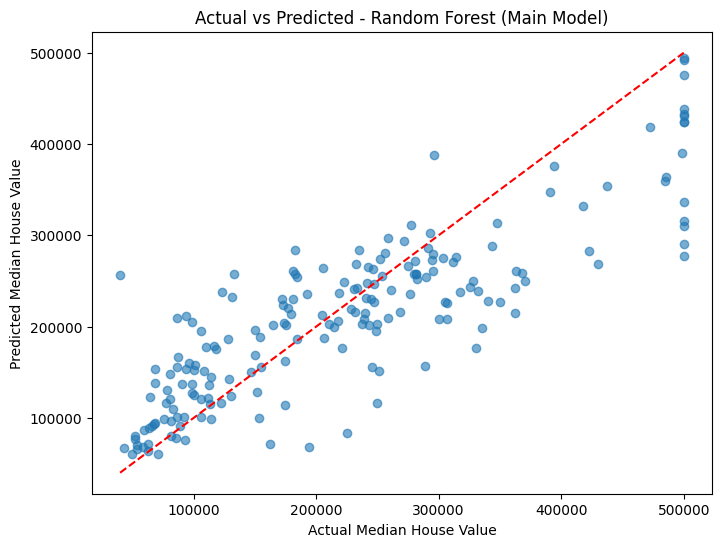

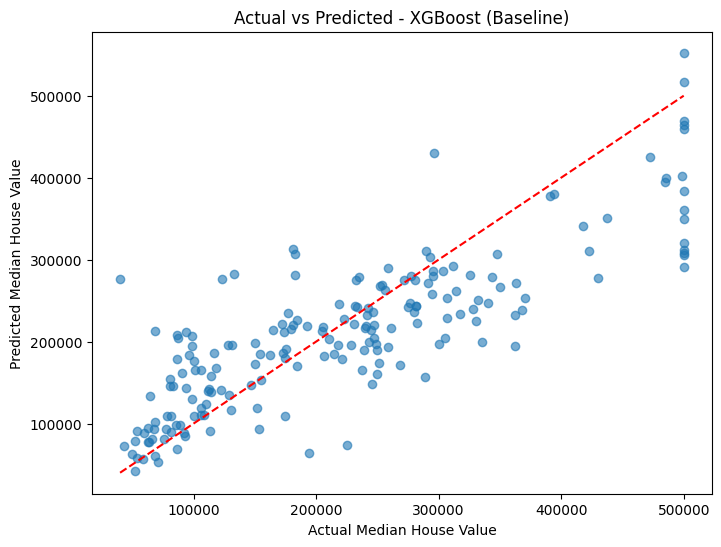

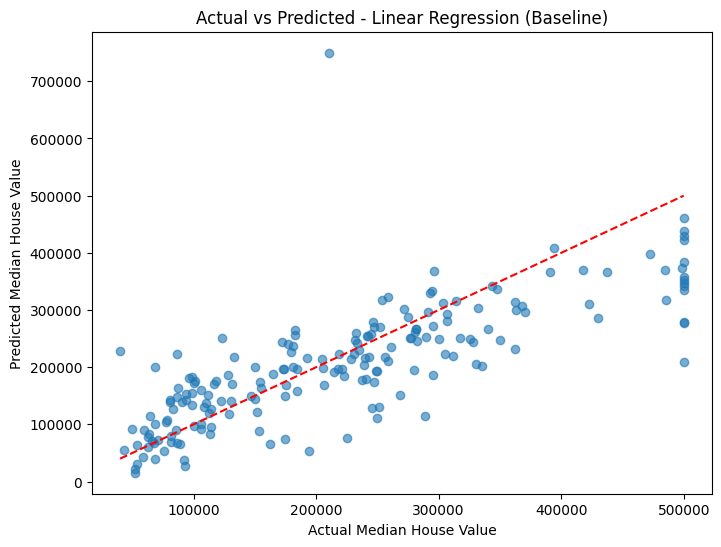

Actual vs Predicted Plots Generated ✅


In [9]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')  # Perfect fit line
    plt.xlabel("Actual Median House Value")
    plt.ylabel("Predicted Median House Value")
    plt.title(f"Actual vs Predicted - {model_name}")
    plt.show()

# Plot for each model
plot_actual_vs_predicted(y_test, y_pred_rf, "Random Forest (Main Model)")
plot_actual_vs_predicted(y_test, y_pred_xgb, "XGBoost (Baseline)")
plot_actual_vs_predicted(y_test, y_pred_linear, "Linear Regression (Baseline)")

print("Actual vs Predicted Plots Generated ✅")
